#### Import Library & Konfigurasi

In [33]:
import pandas as pd
import numpy as np
import warnings
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import smote_variants as sv
import os

warnings.filterwarnings("ignore")

# Konfigurasi File
FILENAME = 'data/2023_imputed.csv' 
TARGET_COLUMN = 'JENIS_TRANSAKSI'

#### Data Loading & Preprocessing

In [34]:
if not os.path.exists(FILENAME):
    print(f"[CRITICAL ERROR] File '{FILENAME}' tidak ditemukan di folder ini.")
else:
    try:
        print(f"Loading dataset '{FILENAME}'...")
        df = pd.read_csv(FILENAME)
        df['PREFIX'] = df['NO_TRANSAKSI'].astype(str).str.split('.').str[0]
        df_clean = df[df['PREFIX'].isin(['1', '2'])].copy()
        df_clean[TARGET_COLUMN] = df_clean['PREFIX'].map({'1': 0, '2': 1})

        print("[Process] Menyeragamkan & Memperbaiki Tanggal...")
        
        df_clean['TANGGAL'] = df_clean['TANGGAL'].astype(str).str.strip()
        
        df_clean['TANGGAL'] = pd.to_datetime(df_clean['TANGGAL'], dayfirst=True, errors='coerce')
        
        n_error = df_clean['TANGGAL'].isnull().sum()
        if n_error > 0:
            print(f"   [Info] Ditemukan {n_error} baris dengan format tanggal rusak.")
            print("   -> Melakukan perbaikan otomatis (mengisi dengan tanggal transaksi sebelumnya)...")
            
            df_clean['TANGGAL'] = df_clean['TANGGAL'].ffill().bfill()
        
        df_clean['BULAN'] = df_clean['TANGGAL'].dt.month

        num_cols = ['QTY_MSK', 'QTY_KLR', 'NILAI_MSK']
        for col in num_cols:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0)

        selected_features = ['NAMA_PRODUK', 'UNIT', 'QTY_MSK', 'QTY_KLR', 'NILAI_MSK', 'BULAN', TARGET_COLUMN]
        df_final = df_clean[selected_features].copy()

        if df_final.isnull().sum().sum() > 0:
            print("[Info] Membersihkan sisa NaN (sangat jarang terjadi)...")
            df_final.fillna(0, inplace=True)

        X = df_final.drop(TARGET_COLUMN, axis=1)
        y = df_final[TARGET_COLUMN].values

        for col in ['NAMA_PRODUK', 'UNIT']:
            X[col] = LabelEncoder().fit_transform(X[col].astype(str))

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )

        print(f"[SUCCESS] Data berhasil diproses!")
        print(f"Dimensi Awal    : {len(df_clean)}")
        print(f"Dimensi Training: {X_train.shape}")
        print(f"Distribusi Label: {dict(zip(*np.unique(y_train, return_counts=True)))}")
        
    except Exception as e:
        print(f"[ERROR] Terjadi kesalahan: {e}")

Loading dataset 'data/2023_imputed.csv'...
[Process] Menyeragamkan & Memperbaiki Tanggal...
   [Info] Ditemukan 97377 baris dengan format tanggal rusak.
   -> Melakukan perbaikan otomatis (mengisi dengan tanggal transaksi sebelumnya)...
[SUCCESS] Data berhasil diproses!
Dimensi Awal    : 161249
Dimensi Training: (128999, 6)
Distribusi Label: {np.int64(0): np.int64(14730), np.int64(1): np.int64(114269)}


#### Definisi Fungsi Algoritma HOUM

In [35]:
def svm_undersampling_step(X, y, drop_percent=0.2):
    unique, counts = np.unique(y, return_counts=True)
    maj_label = unique[np.argmax(counts)]
    min_label = unique[np.argmin(counts)]

    maj_indices = np.where(y == maj_label)[0]
    min_indices = np.where(y == min_label)[0]

    # Sampling untuk mempercepat training SVM jika data > 20k
    if len(X) > 20000:
        idx_sample = np.random.choice(len(X), 20000, replace=False)
        svm = SVC(kernel='linear', C=1.0)
        svm.fit(X[idx_sample], y[idx_sample])
    else:
        svm = SVC(kernel='linear', C=1.0)
        svm.fit(X, y)

    # Hitung jarak ke hyperplane
    dists = svm.decision_function(X[maj_indices])
    abs_dists = np.abs(dists)

    # Buang data mayoritas terjauh
    n_drop = int(len(maj_indices) * drop_percent)
    sorted_idx_args = np.argsort(abs_dists)
    indices_kept = maj_indices[sorted_idx_args[:-n_drop]]

    final_indices = np.concatenate([min_indices, indices_kept])
    return X[final_indices], y[final_indices]

def sls_oversampling_step(X, y):
    unique, counts = np.unique(y, return_counts=True)
    n_min = np.min(counts)
    
    k = min(5, n_min - 1)
    if k < 1: return X, y

    oversampler = sv.Safe_Level_SMOTE(proportion=1.0, k=k)
    X_res, y_res = oversampler.sample(X, y)
    return X_res, y_res

def run_iterative_houm(X, y, max_iter=10):
    print("=== MULAI ITERASI HOUM ===")
    start_time = time.time()
    X_curr, y_curr = X.copy(), y.copy()

    for i in range(max_iter):
        unique, counts = np.unique(y_curr, return_counts=True)
        if len(counts) < 2: break

        min_count = np.min(counts)
        total_count = np.sum(counts)
        ratio = min_count / total_count

        print(f"Iterasi {i+1} | Total: {total_count} | Rasio Minoritas: {ratio:.2%}")

        if 0.45 <= ratio <= 0.55:
            print("-> Status: Seimbang (Optimal).")
            break

        X_curr, y_curr = svm_undersampling_step(X_curr, y_curr, drop_percent=0.15)
        X_curr, y_curr = sls_oversampling_step(X_curr, y_curr)

    print(f"=== Selesai ({time.time()-start_time:.2f} detik) ===")
    
    # Plot Distribusi
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.countplot(x=y, ax=ax[0], palette='Reds')
    ax[0].set_title("Sebelum")
    sns.countplot(x=y_curr, ax=ax[1], palette='Greens')
    ax[1].set_title("Sesudah (HOUM)")
    plt.tight_layout()
    plt.show()

    return X_curr, y_curr

#### Fungsi Evaluasi

In [36]:
def evaluate_model(X_tr, y_tr, X_ts, y_ts, title):
    print(f"\n--- EVALUASI: {title} ---")

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=300,
        random_state=42
    )
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_ts)

    tn, fp, fn, tp = confusion_matrix(y_ts, y_pred).ravel()
    
    acc = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    g_mean = math.sqrt(recall * specificity)

    print(f"Accuracy    : {acc:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall      : {recall:.4f}")
    print(f"F1-Score    : {f1_score:.4f}")
    print(f"G-Mean      : {g_mean:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print("-" * 30)
    print(f"Confusion Matrix -> TP: {tp} | TN: {tn} | FP: {fp} | FN: {fn}")

    cm = np.array([[tn, fp], [fn, tp]])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Masuk (0)', 'Keluar (1)'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{title}\nG-Mean: {g_mean:.3f} | Acc: {acc:.3f}")
    plt.grid(False)
    plt.show()

#### Eksekusi Pipeline

=== MULAI ITERASI HOUM ===
Iterasi 1 | Total: 128999 | Rasio Minoritas: 11.42%


2025-12-01 13:00:05,356:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'random_state': None, 'class_name': 'Safe_Level_SMOTE'}")
2025-12-01 13:00:05,357:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-12-01 13:00:05,539:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Iterasi 2 | Total: 194258 | Rasio Minoritas: 50.00%
-> Status: Seimbang (Optimal).
=== Selesai (13.25 detik) ===


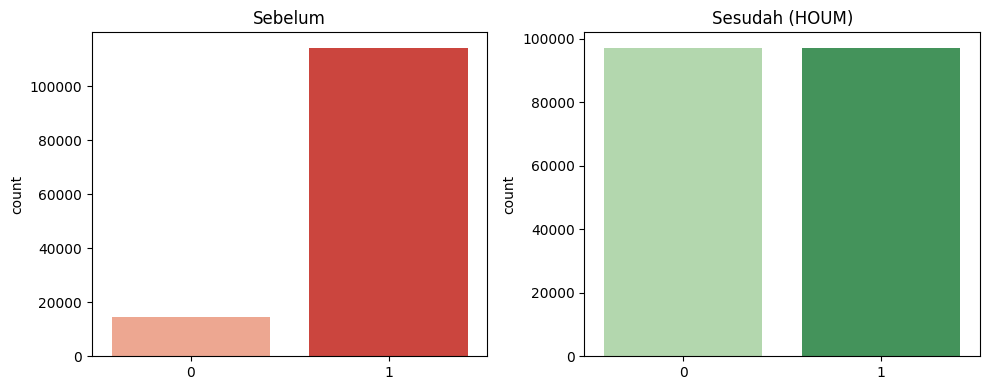


--- EVALUASI: Baseline (Imbalanced) ---
Accuracy    : 0.9791
Precision   : 0.9846
Recall      : 0.9918
F1-Score    : 0.9882
G-Mean      : 0.9342
Specificity : 0.8800
------------------------------
Confusion Matrix -> TP: 28335 | TN: 3240 | FP: 442 | FN: 233


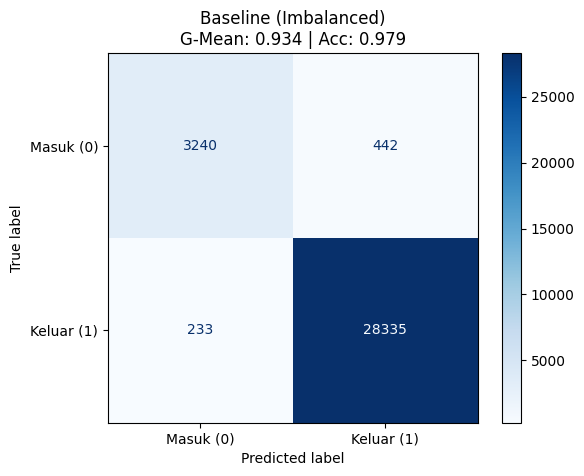


--- EVALUASI: HOUM Iteratif ---
Accuracy    : 0.8554
Precision   : 0.9873
Recall      : 0.8477
F1-Score    : 0.9122
G-Mean      : 0.8808
Specificity : 0.9153
------------------------------
Confusion Matrix -> TP: 24216 | TN: 3370 | FP: 312 | FN: 4352


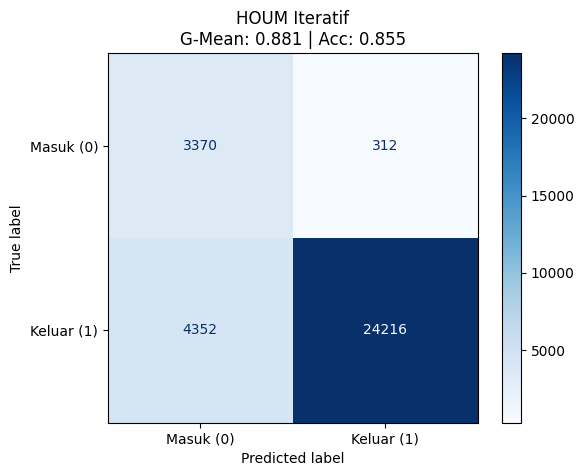

In [37]:
# 1. Jalankan Balancing HOUM
if 'X_train' in locals():
    X_houm_iter, y_houm_iter = run_iterative_houm(X_train, y_train)

# 2. Evaluasi Baseline
evaluate_model(X_train, y_train, X_test, y_test, "Baseline (Imbalanced)")

# 3. Evaluasi Hasil HOUM
if 'X_houm_iter' in locals():
    evaluate_model(X_houm_iter, y_houm_iter, X_test, y_test, "HOUM Iteratif")

#### Export Dataset ke CSV

In [38]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder

print("--- MENGEKSPOR DATA ---")

if 'X_houm_iter' in locals() and 'y_houm_iter' in locals():
    
    try:
        print("[Auto-Fix] Memuat ulang scaler dari data asli...")
        FILENAME = 'data/2023_imputed.csv' 
        TARGET_COLUMN = 'JENIS_TRANSAKSI'
        
        df_raw = pd.read_csv(FILENAME)
        df_raw['PREFIX'] = df_raw['NO_TRANSAKSI'].astype(str).str.split('.').str[0]
        df_clean = df_raw[df_raw['PREFIX'].isin(['1', '2'])].copy()
        df_clean[TARGET_COLUMN] = df_clean['PREFIX'].map({'1': 0, '2': 1})
        df_clean['TANGGAL'] = pd.to_datetime(df_clean['TANGGAL'], dayfirst=True, errors='coerce')
        df_clean['BULAN'] = df_clean['TANGGAL'].dt.month
        
        selected_features = ['NAMA_PRODUK', 'UNIT', 'QTY_MSK', 'QTY_KLR', 'NILAI_MSK', 'BULAN', TARGET_COLUMN]
        df_final = df_clean[selected_features]
        
        X_raw = df_final.drop(TARGET_COLUMN, axis=1)
        for col in ['NAMA_PRODUK', 'UNIT']:
            X_raw[col] = LabelEncoder().fit_transform(X_raw[col].astype(str))
            
        scaler_fix = StandardScaler()
        scaler_fix.fit(X_raw) 
        print("[Auto-Fix] Scaler berhasil dibuat ulang.")
        
    except Exception as e:
        print(f"[CRITICAL ERROR] Gagal membuat ulang scaler: {e}")
        scaler_fix = None

    # 3. PROSES EKSPOR
    if scaler_fix:
        try:
            feature_cols = ['NAMA_PRODUK', 'UNIT', 'QTY_MSK', 'QTY_KLR', 'NILAI_MSK', 'BULAN']
            
            print("[Process] Mengembalikan angka ke format asli (Rupiah/Qty)...")
            X_real = scaler_fix.inverse_transform(X_houm_iter)
            
            df_export = pd.DataFrame(X_real, columns=feature_cols)
            cols_to_int = ['NAMA_PRODUK', 'UNIT', 'QTY_MSK', 'QTY_KLR', 'BULAN']
            for col in cols_to_int:
                df_export[col] = df_export[col].abs().round(0).astype(int)
            
            df_export['NILAI_MSK'] = df_export['NILAI_MSK'].round(2)
            df_export['JENIS_TRANSAKSI'] = y_houm_iter
            df_export['KETERANGAN'] = df_export['JENIS_TRANSAKSI'].map({0: 'Masuk', 1: 'Keluar'})

            output_filename = "hasil/HOUM_Dataset_Balanced_2023.csv"
            df_export.to_csv(output_filename, index=False)
            
            print(f"\n[SUKSES] File tersimpan: {output_filename}")
            print(f"Lokasi: {os.getcwd()}")
            print("-" * 40)
            print(df_export[['QTY_MSK', 'QTY_KLR', 'NILAI_MSK', 'KETERANGAN']].head().to_string(index=False))
            
        except Exception as e:
            print(f"[ERROR] Gagal saat inverse transform: {e}")
    else:
        print("[STOP] Tidak bisa ekspor karena Scaler gagal dibuat.")

else:
    print("[ERROR] Variabel X_houm_iter (Data Balanced) tidak ditemukan.")
    print("Solusi: Jalankan Cell 5 (Pipeline) dulu.")

--- MENGEKSPOR DATA ---
[Auto-Fix] Memuat ulang scaler dari data asli...
[Auto-Fix] Scaler berhasil dibuat ulang.
[Process] Mengembalikan angka ke format asli (Rupiah/Qty)...

[SUKSES] File tersimpan: hasil/HOUM_Dataset_Balanced_2023.csv
Lokasi: e:\KIKI\Data Mining\UAS-Penambangan-Data
----------------------------------------
 QTY_MSK  QTY_KLR  NILAI_MSK KETERANGAN
      10       10    6633.76      Masuk
       1        1    6109.12      Masuk
      12       12    6500.28      Masuk
      10        9    3425.28      Masuk
      20       20   75000.00      Masuk
